In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# EDA

In [23]:
#Load dataset
df = pd.read_csv('jm_train.csv')
df.head()

feature1  feature2  feature3  feature4  feature5  feature6  target
0  0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367       4
1 -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838       0
2 -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928       1
3 -1.268179  2.770688  1.054193  2.830389  0.395093  0.677715       3
4 -1.216380 -0.391267 -2.898931 -0.913074 -2.171857 -2.367490       0

array([[<AxesSubplot:title={'center':'feature1'}>,
        <AxesSubplot:title={'center':'feature2'}>,
        <AxesSubplot:title={'center':'feature3'}>],
       [<AxesSubplot:title={'center':'feature4'}>,
        <AxesSubplot:title={'center':'feature5'}>,
        <AxesSubplot:title={'center':'feature6'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

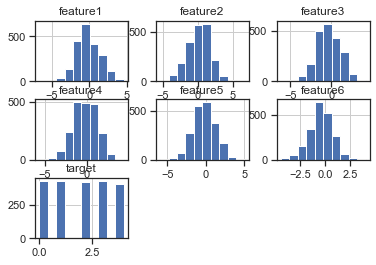

In [24]:
df.hist()

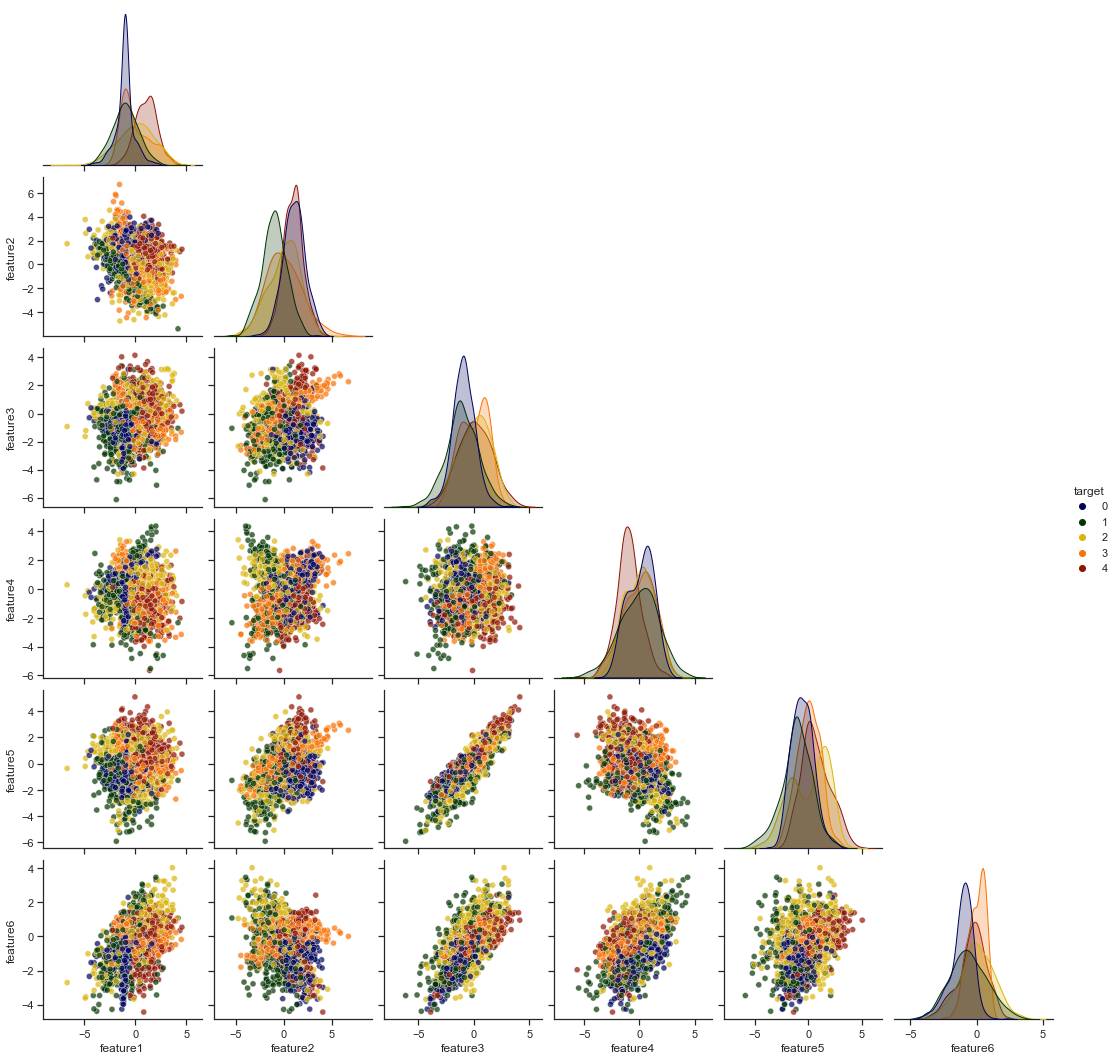

In [5]:
sns.set(style="ticks", color_codes=True);

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange', 'brick red'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(df, hue='target', diag_kind='kde', corner=True, palette=palette, plot_kws=dict(alpha = 0.7), diag_kws=dict(shade=True))

<AxesSubplot:>

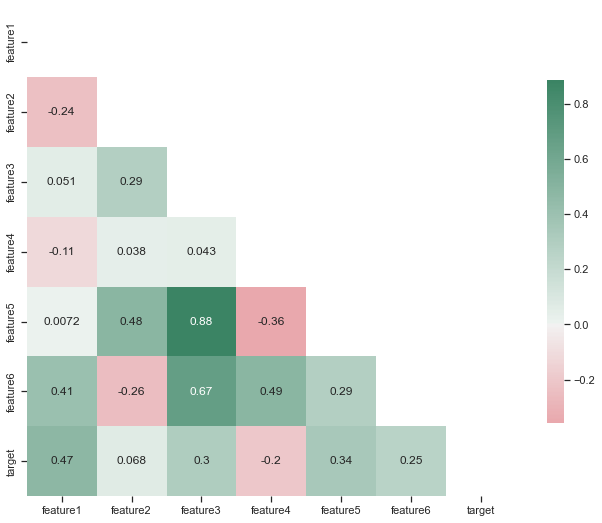

In [62]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .7}, annot=True)

# Base Random Forest

In [91]:
# Find the best train/test ratio

X = df[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6']]
y = df['target']

tt_split = []
precision = []
for t in np.linspace(0.05,.35,num=20):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, random_state=42) # 70% training and 30% test

    #Create a Gaussian Classifier
    model = RandomForestClassifier() # n_estimators=1155, min_samples_split=2, min_samples_leaf=1, max_features='auto',max_depth=None,bootstrap=True)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    tt_split.append(t)
    precision.append(metrics.accuracy_score(y_test, y_pred))
    # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

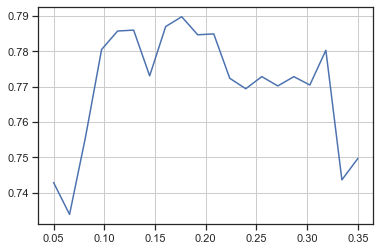

In [92]:
df_metrics = pd.DataFrame({'t':tt_split, 'acc':precision})
plt.plot(df_metrics['t'], df_metrics['acc'])
plt.grid()

In [93]:
# Optimal train/test ratio
df_metrics[df_metrics['acc'] == df_metrics['acc'].max()]

t       acc
8  0.176316  0.789757

# Base Random Forest model

In [94]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test

#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


# Hyperparameter Tuning

In [95]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 10, 20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

In [96]:
random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'log2', None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10, 20, 50, 100],
 'min_samples_leaf': [1, 2, 4, 5, 10, 20],
 'bootstrap': [True, False]}

In [97]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = None, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train,y_train)

y_pred = rf_random.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Accuracy: 0.8


In [89]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)
print("\n The best score across ALL searched params:\n", rf_random.best_score_)
print("\n The best parameters across ALL searched params:\n", rf_random.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=50, max_features=None, min_samples_split=5,
                       n_estimators=311)

 The best score across ALL searched params:
 0.7244047619047619

 The best parameters across ALL searched params:
 {'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True}


In [110]:
rf_model = rf_random.best_estimator_
y_pred = rf_model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


# Grid Search

In [101]:
# Tried to do a Grid Search for more fine parameter tuning but the precision was decreasing

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [200,300,400],
    'min_samples_split': [3,5,7],
    'min_samples_leaf': [1,2,3],
    'max_features': [None],
    'max_depth': [30,50,60],
    'bootstrap': [True],
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': True,
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 200}

In [102]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=30, max_features=None, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=200)

 The best score across ALL searched params:
 0.7482142857142856

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


In [109]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7880952380952381


# Show single tree

In [129]:
from sklearn.tree import export_graphviz

estimator = rf_model.estimators_[0]

feature_list = list(df.columns[:-1])
target_names = [str(i) for i in set(df['target'])]

# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = feature_list,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Test output

In [112]:
dtest = pd.read_csv('jm_X_test.csv')

In [114]:
y_output = rf_model.predict(dtest)

In [128]:
y_output.tofile("jm_Y_pred.csv", sep='\n')